## Download the data

In [1]:
import requests
quakes_response=requests.get("http://earthquake.usgs.gov/fdsnws/event/1/query.geojson",
                    params={
        'starttime':"2000-01-01",
        "maxlatitude":"58.723",
        "minlatitude":"50.008",
        "maxlongitude":"1.67",
        "minlongitude":"-9.756",
        "minmagnitude":"1",
        "endtime":"2015-07-13",
        "orderby":"time-asc"}
                   )

In [4]:
quakes_response

<Response [200]>

In [5]:
type(quakes_response)

requests.models.Response

## Parse the data as JSON

In [2]:
import json

In [3]:
requests_json = json.loads(quakes_response.text)

## Investigate the data to discover how it is structured.

In [6]:
type(requests_json)

dict

In [7]:
requests_json.keys()

[u'type', u'features', u'bbox', u'metadata']

In [8]:
type(requests_json['features'])

list

In [16]:
len(requests_json['features'])

110

In [9]:
type(requests_json['features'][0])

dict

In [17]:
requests_json['features'][0].keys()

[u'geometry', u'type', u'properties', u'id']

In [18]:
requests_json['features'][0]['properties']['mag']

2.6

In [10]:
requests_json['features'][0]['geometry']['coordinates']

[-2.81, 54.77, 14]

## Find the largest quake

In [12]:
quakes = requests_json['features']

In [13]:
largest_so_far = quakes[0]

for quake in quakes:
    if quake['properties']['mag'] > largest_so_far['properties']['mag']:
        largest_so_far = quake
        
largest_so_far

{u'geometry': {u'coordinates': [-2.15, 52.52, 9.4], u'type': u'Point'},
 u'id': u'usp000bcxg',
 u'properties': {u'alert': None,
  u'cdi': None,
  u'code': u'p000bcxg',
  u'detail': u'http://earthquake.usgs.gov/fdsnws/event/1/query?eventid=usp000bcxg&format=geojson',
  u'dmin': None,
  u'felt': None,
  u'gap': None,
  u'ids': u',usp000bcxg,atlas20020922235314,',
  u'mag': 4.8,
  u'magType': u'mb',
  u'mmi': None,
  u'net': u'us',
  u'nst': 268,
  u'place': u'England, United Kingdom',
  u'rms': None,
  u'sig': 354,
  u'sources': u',us,atlas,',
  u'status': u'reviewed',
  u'time': 1032738794600,
  u'title': u'M 4.8 - England, United Kingdom',
  u'tsunami': 0,
  u'type': u'earthquake',
  u'types': u',impact-text,origin,phase-data,',
  u'tz': None,
  u'updated': 1426874123970,
  u'url': u'http://earthquake.usgs.gov/earthquakes/eventpage/usp000bcxg'},
 u'type': u'Feature'}

In [14]:
        
print largest_so_far['properties']['mag']

4.8


In [15]:
lat=largest_so_far['geometry']['coordinates'][1]
long=largest_so_far['geometry']['coordinates'][0]
print "Latitude:", lat, "Longitude:", long

Latitude: 52.52 Longitude: -2.15


## Get a map at the point of the quake

In [16]:
import requests
def request_map_at(lat,long, satellite=False,zoom=12,size=(400,400),sensor=False):
  base="http://maps.googleapis.com/maps/api/staticmap?"
  
  params=dict(
    sensor= str(sensor).lower(),
    zoom= zoom,
    size= "x".join(map(str,size)),
    center= ",".join(map(str,(lat,long)))
  )
  if satellite:
    params["maptype"]="satellite"

  return requests.get(base,params=params)

In [17]:
import IPython
map_png=request_map_at(lat, long,zoom=10)

## Display the map

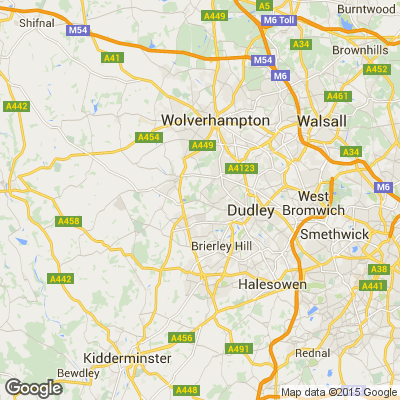

In [18]:
IPython.core.display.Image(map_png.content)

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline

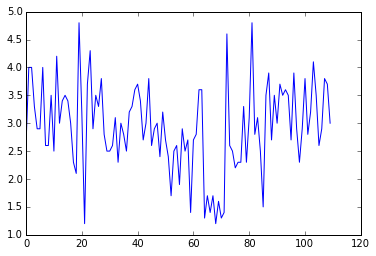

In [20]:
plt.plot([  quake['properties']['mag'] for quake in quakes  ]) 